## Processing a classification dataset

The dataset which will be used can be found here [Titanic](https://www.kaggle.com/competitions/titanic).

Main goal is to improve the general classification result which is defined as accuracy 

There will be: 
1. Checking the accuracy before applaing any preprocessing algorithms
2. Analyzing our data
3. Using preprocessing algorithms:
- Feature normalization and standardization
- Feature selection  
- Feature extraction
4. Comparing the results

In [1]:
### libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, GenericUnivariateSelect, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap

c:\Users\Susanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reading the data

data = pd.read_csv('train.csv')
total_rows = len(data)
split_index = int(0.6 * total_rows)

data_df = pd.DataFrame(data.iloc[:split_index])
test_df = pd.DataFrame(data.iloc[split_index:])

**1.Checking the accuracy**

In [3]:
# checking the initial accuarcy ->>>>>> TO CHECK 

classifier = SVC()
pd.options.mode.copy_on_write = True

X = data_df[['Pclass','Age','Fare','Sex']]
X['Sex'] = X.Sex.copy().apply(lambda x : 1.0 if x == 'male' else 2.0).copy()
X = X.fillna(0)
X = X.to_numpy()
y = data_df['Survived']

y = y.to_numpy()

X_test = test_df[['Pclass','Age','Fare','Sex']]
X_test.Sex = X_test.Sex.apply(lambda x : 1.0 if x == 'male' else 2.0)
X_test = X_test.fillna(0)
X_test = X_test.to_numpy()
y_test = test_df['Survived']
y_test = y_test.to_numpy()

classifier.fit(X,y)
predicts = classifier.predict(X_test)
report = classification_report(y_test, predicts)
accuracy_before = accuracy_score(y_test, predicts)

print("Accuracy before preprocessing: ", accuracy_before)

Accuracy before preprocessing:  0.6974789915966386


**2.Analyzing our data**

In [4]:
headers = data_df.columns.to_list()
procentage = []
for head in headers:
    procentage.append( round((data_df[head].nunique()/ len(data_df[head])),3))

variable_types = ['discrete (unique)', 'discrete', 'discrete', 'discrete', 'categorical', 'continuous', 'discrete', 'discrete', 'discrete', 'continuous', 'categorical','categorical']
variable_df = pd.DataFrame({'Column': headers, 'Variable_Type': variable_types, 'the percentage values of unique values': procentage})
variable_df

,Column,Variable_Type,the percentage values of unique values
0,PassengerId,discrete (unique),1.000
1,Survived,discrete,0.004
2,Pclass,discrete,0.006
3,Name,discrete,1.000
4,Sex,categorical,0.004
5,Age,continuous,0.144
6,SibSp,discrete,0.013
7,Parch,discrete,0.011
8,Ticket,discrete,0.835
9,Fare,continuous,0.375


- fill NaN values with mean value

In [5]:
## change all NaN values to mean or mode
# print('NaN values for Embarked: ',data_df['Embarked'].isnull().sum())
# print('NaN values for Cabin: ',data_df['Cabin'].isnull().sum())
# print('NaN values for Age: ',data_df['Age'].isnull().sum())

embarked_mode = data_df['Embarked'].mode()[0]
cabin_mode = data_df['Cabin'].mode()[0]
age_mean = round(data_df['Age'].mean(),2)

for index, row in data_df.iterrows():
    if pd.isnull(row['Age']):
        data_df.at[index, 'Age'] = age_mean

    if pd.isnull(row['Embarked']):
        data_df.at[index, 'Embarked'] = embarked_mode

    if pd.isnull(row['Cabin']):
        data_df.at[index, 'Cabin'] = cabin_mode

# print('NaN values for Embarked after: ',data_df['Embarked'].isnull().sum())
# print('NaN values for Cabin after: ',data_df['Cabin'].isnull().sum())
# print('NaN values for Age after: ',data_df['Age'].isnull().sum())

## changing caterogical attributes to discrete
columns_to_change = ['Sex', 'Cabin', 'Embarked', 'Name', 'Ticket']

label_encoder = LabelEncoder()
for column in columns_to_change:
    data_df[column] = label_encoder.fit_transform(data_df[column])

# data_df.head()

**3.1.Normalization and standarization**

In [6]:
## Normalization and standarization
X = pd.concat([data_df.iloc[:, :1], data_df.iloc[:, 2:]], axis=1)
cols_all = data_df.columns.tolist()
cols = cols_all[:1] + cols_all[2:]

norm = MinMaxScaler(feature_range=(0,1)).fit(X)
normalized_data = pd.DataFrame(norm.transform(X), columns=cols)

scale = StandardScaler().fit(normalized_data)
standarized_data = pd.DataFrame(scale.transform(normalized_data), columns=cols)

In [7]:
#### the same for test set
for index, row in test_df.iterrows():
    if pd.isnull(row['Age']):
        test_df.at[index, 'Age'] = age_mean

    if pd.isnull(row['Embarked']):
        test_df.at[index, 'Embarked'] = embarked_mode

    if pd.isnull(row['Cabin']):
        test_df.at[index, 'Cabin'] = cabin_mode

# Changing categorical attributes to discrete
columns_to_change = ['Sex', 'Cabin', 'Embarked', 'Name', 'Ticket']

label_encoder = LabelEncoder()
for column in columns_to_change:
    test_df[column] = label_encoder.fit_transform(test_df[column])

# Normalization and standardization
X_2 = pd.concat([test_df.iloc[:, :1], test_df.iloc[:, 2:]], axis=1)
cols_ = test_df.columns.tolist()
cols_all_2 = cols_all[:1] + cols_all[2:]

norm_2 = MinMaxScaler(feature_range=(0, 1)).fit(X_2)
normalized_data_2 = pd.DataFrame(norm_2.transform(X_2), columns=cols_all_2)

# scale_2 = StandardScaler().fit(normalized_data_2)
# normalized_data_2 = pd.DataFrame(scale_2.transform(normalized_data_2), columns=cols_all_2)

normalized_data_2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.000000,1.0,0.134831,0.0,0.371701,0.0,0.000000,0.408497,0.016908,0.444444,1.0
1,0.002809,0.5,0.396067,0.0,0.082684,0.0,0.333333,0.849673,0.051237,0.444444,1.0
2,0.005618,0.0,0.129213,1.0,0.560191,0.0,0.000000,0.032680,0.051822,0.194444,1.0
3,0.008427,0.0,0.553371,0.0,0.371701,0.0,0.000000,0.915033,0.207728,0.444444,0.0
4,0.011236,1.0,0.789326,1.0,0.362403,0.0,0.000000,0.653595,0.028302,0.444444,1.0


In [8]:
### checking the accuraccy after (all columns taking into account)
#### AFTER ####################### CORRECT?

X = normalized_data
X = X.to_numpy()
y = data_df['Survived']
y = y.to_numpy()

X_test = normalized_data_2
X_test = X_test.to_numpy()
y_test = test_df['Survived']
y_test = y_test.to_numpy()

classifier.fit(X,y)
predicts = classifier.predict(X_test)
report = classification_report(y_test, predicts)
accuracy_after_1 = accuracy_score(y_test, predicts)

print("Accuracy after preprocessing: ", accuracy_after_1)

Accuracy after preprocessing:  0.7927170868347339


**3.2.Feature selection**


1. Normalization and standrization do not have any influence on corellation, therefore we do it on the initialy dataframe to see correlation between target value and other attribute too. (Notice, that the correlation values don't change if we do not apply normalization schema). Present them on heatmap

2. Instead of using variances to collect the best features we will use the ranking function ([f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)). This method calculates the F coefficients and p-values for each feature in the context of classification. The higher the F coefficient, the more significant the feature is for classification

<AxesSubplot: >

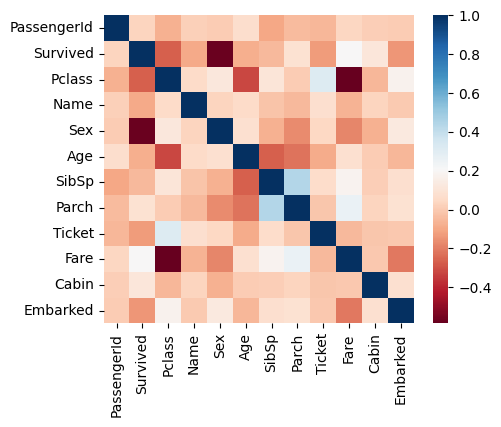

In [9]:
plt.figure(figsize=(5,4))
sns.heatmap(data_df.corr(), cmap='RdBu')

<AxesSubplot: title={'center': 'ANOVA'}>

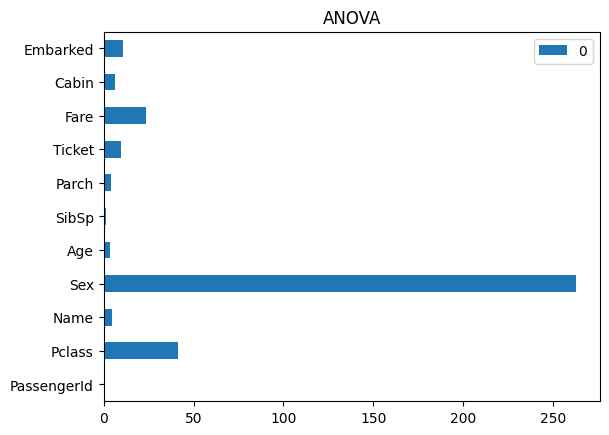

In [10]:
cols_all = data_df.columns.tolist()
cols = cols_all[:1] + cols_all[2:]
scores_anova, p_vals_anova = f_classif(normalized_data, data_df['Survived'])
pd.DataFrame(scores_anova, cols).plot(kind='barh', title='ANOVA')

     Pclass  Sex      Fare  Embarked
0       1.0  1.0  0.014151       1.0
1       0.0  0.0  0.139136       0.0
2       1.0  0.0  0.015469       1.0
3       0.0  0.0  0.103644       1.0
4       1.0  1.0  0.015713       1.0
..      ...  ...       ...       ...
529     0.5  1.0  0.022447       1.0
530     0.5  0.0  0.050749       1.0
531     1.0  1.0  0.014110       0.0
532     1.0  1.0  0.014110       0.0
533     1.0  0.0  0.043640       0.0

[534 rows x 4 columns]


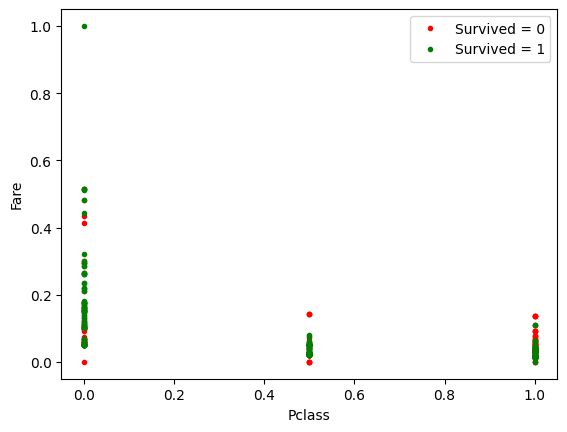

In [11]:
gus_object = GenericUnivariateSelect(chi2, mode='k_best', param=4)

new_data = gus_object.fit_transform(normalized_data, data_df['Survived'])
new_dataframe = pd.DataFrame(new_data, columns=gus_object.get_feature_names_out())
print(new_dataframe) # we now all possible columns to choose

plt.plot(new_dataframe[new_dataframe.columns[0]][data_df['Survived'] == 0], new_dataframe[new_dataframe.columns[2]][data_df['Survived'] == 0], 'r.', label='Survived = 0')
plt.plot(new_dataframe[new_dataframe.columns[0]][data_df['Survived'] == 1], new_dataframe[new_dataframe.columns[2]][data_df['Survived'] == 1], 'g.', label='Survived = 1')
plt.xlabel(gus_object.get_feature_names_out()[0])
plt.ylabel(gus_object.get_feature_names_out()[2])
plt.legend()
plt.show()


Summary:

- From heatmap, we can get info that the 'Patch' or 'SibSp' can be delated becasue they are high correleted
- From the ANOVA plot we know that 'Sex','Pclass' and 'Fare' are good for ou classification
- The last plot is not good, because we do not have much continuous values, therfore it mostly makes 2 or 4 points on the plot only

In [12]:
##### droping some columns
columns_to_stay = ['Sex', 'Fare', 'Pclass', 'Survived']
for column in data_df.columns.tolist():
    if column not in columns_to_stay:
        normalized_data.drop(column, axis=1, inplace=True)
        normalized_data_2.drop(column, axis=1, inplace=True)

# print(normalized_data)

#  checking the accuraccy after
#### AFTER  SELECTION ####################### CORRECT?

X = normalized_data
X = X.to_numpy()
y = data_df['Survived']
y = y.to_numpy()

X_test = normalized_data_2
X_test = X_test.to_numpy()
y_test = test_df['Survived']
y_test = y_test.to_numpy()

classifier.fit(X,y)
predicts = classifier.predict(X_test)
report = classification_report(y_test, predicts)
accuracy_after_2 = accuracy_score(y_test, predicts)

print("Accuracy after preprocessing: ", accuracy_after_2)

Accuracy after preprocessing:  0.7675070028011205


**3.3.Feature extraction**

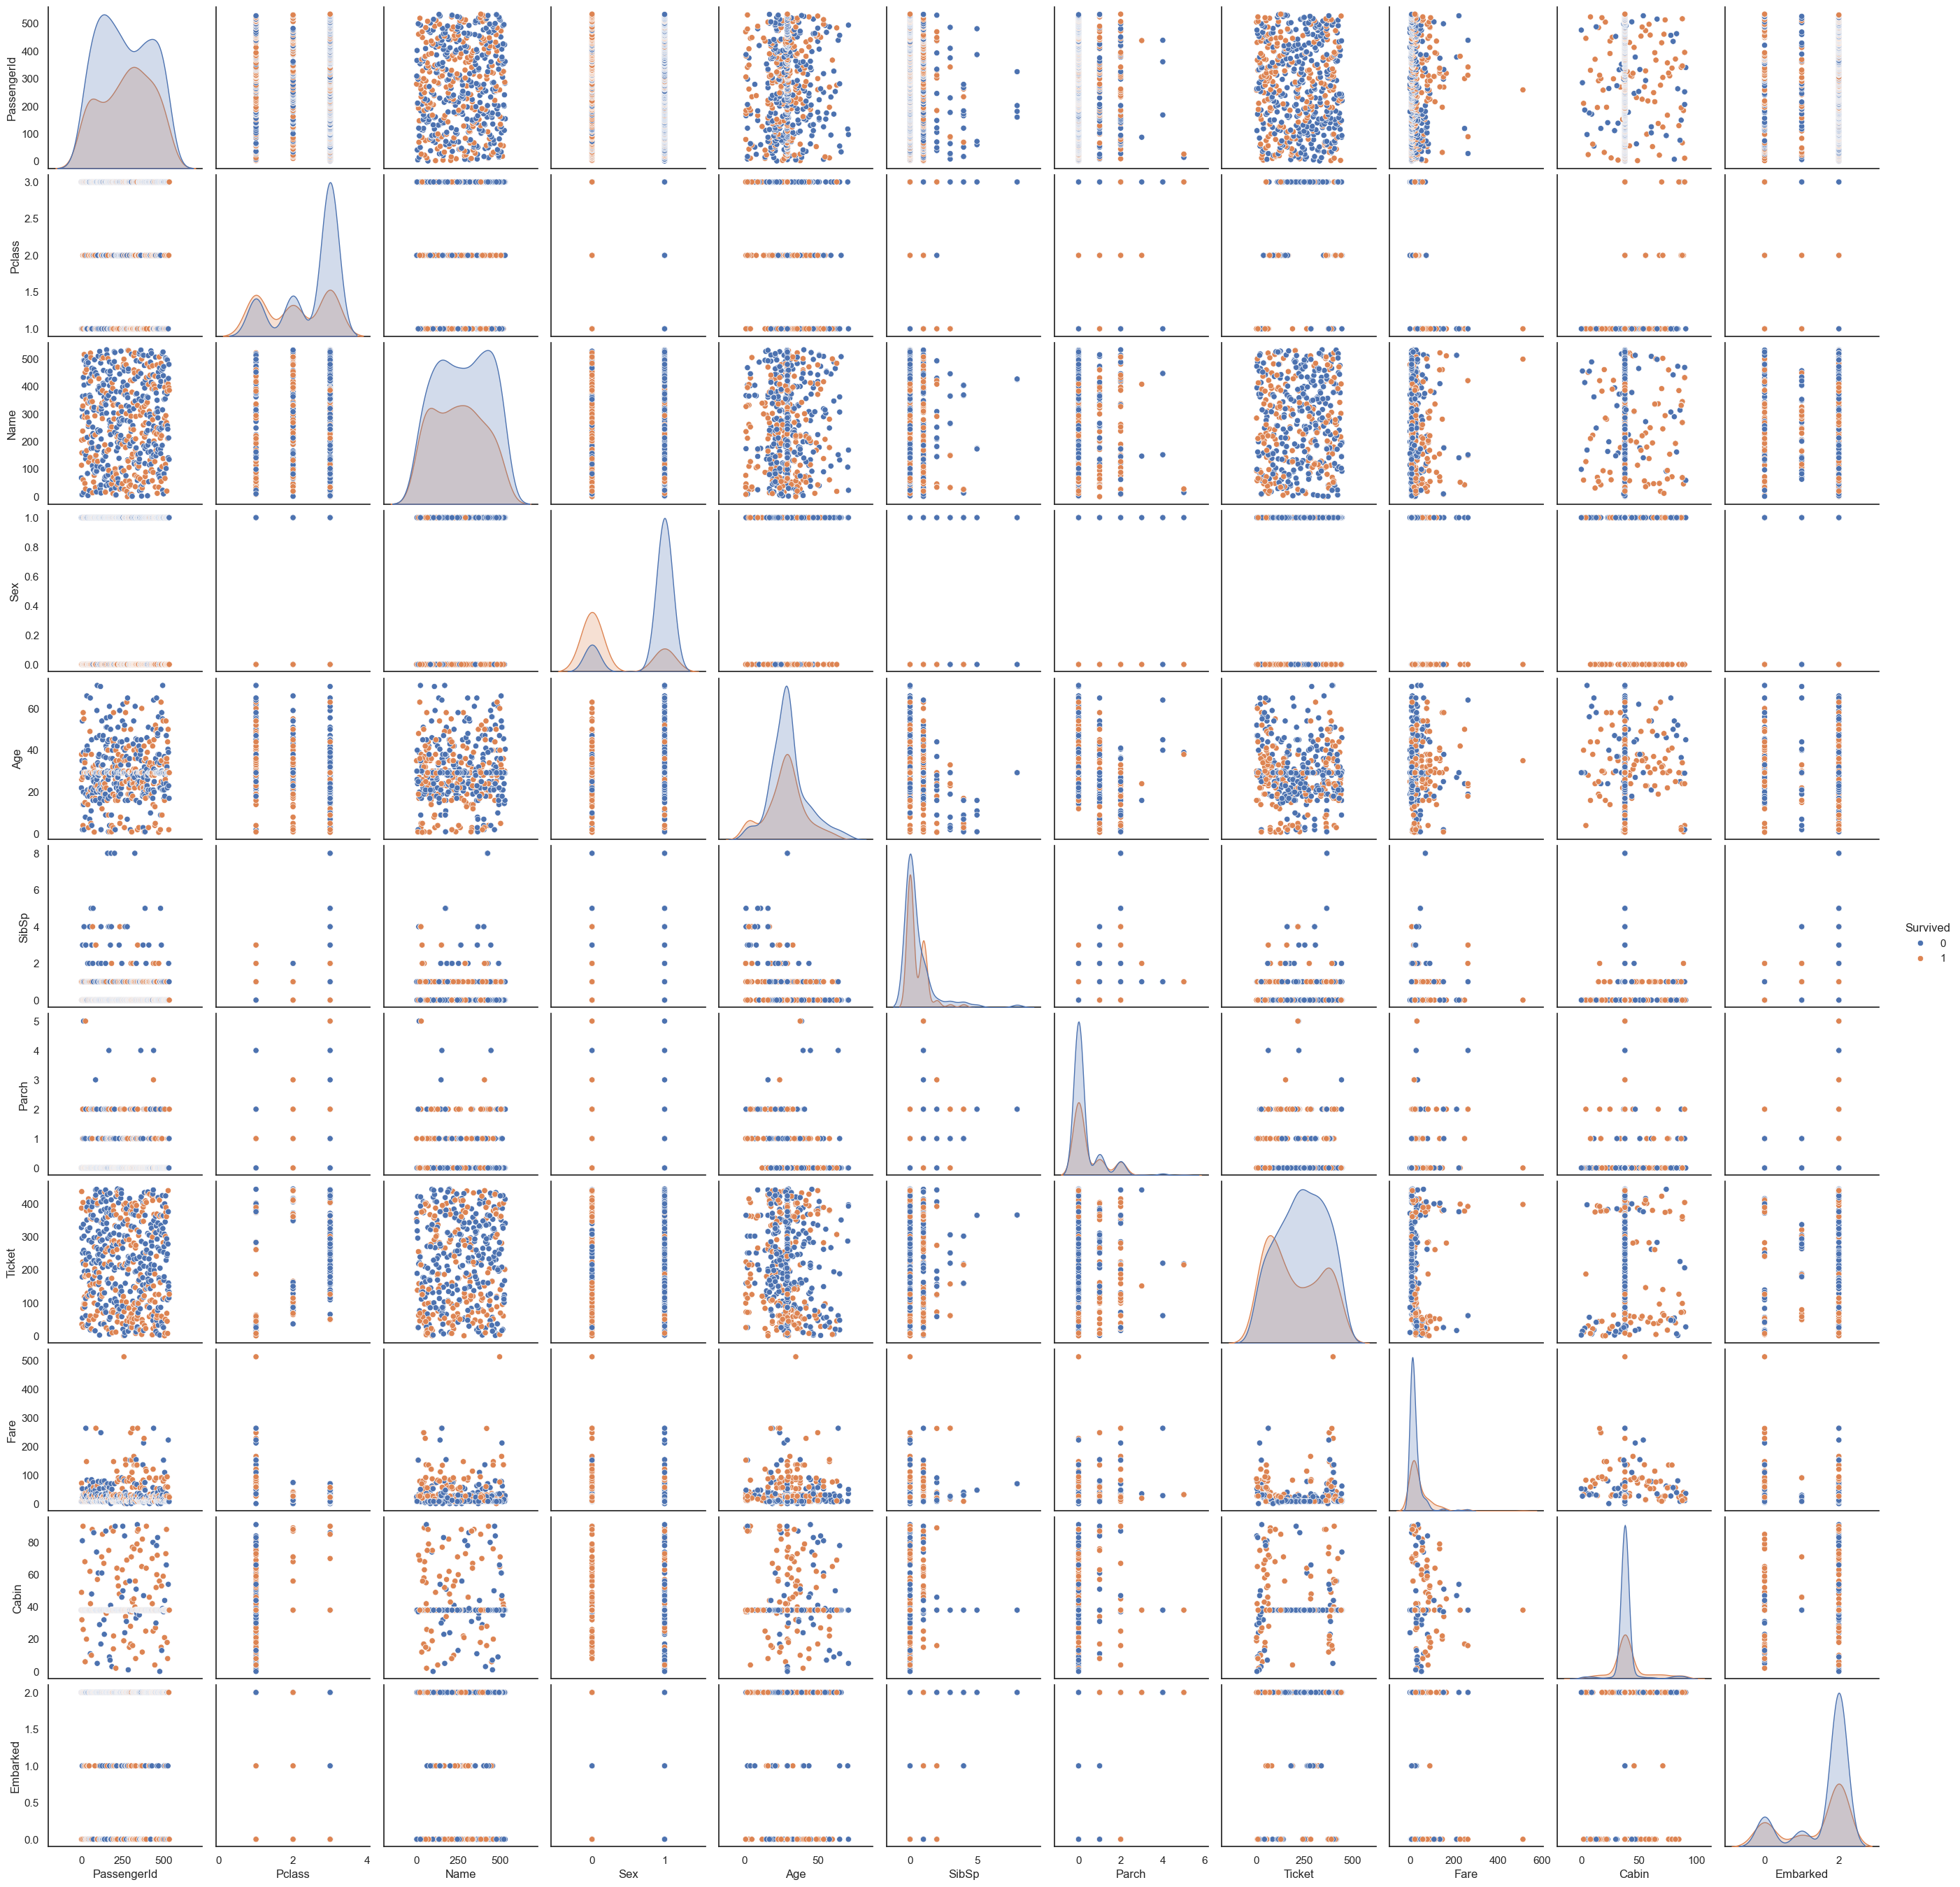

In [13]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.DataFrame(data_df, columns=data_df.columns.tolist())
sns.pairplot(df, hue='Survived')

Text(0.5, 1.0, 'UMAP projection of Titanic dataset')

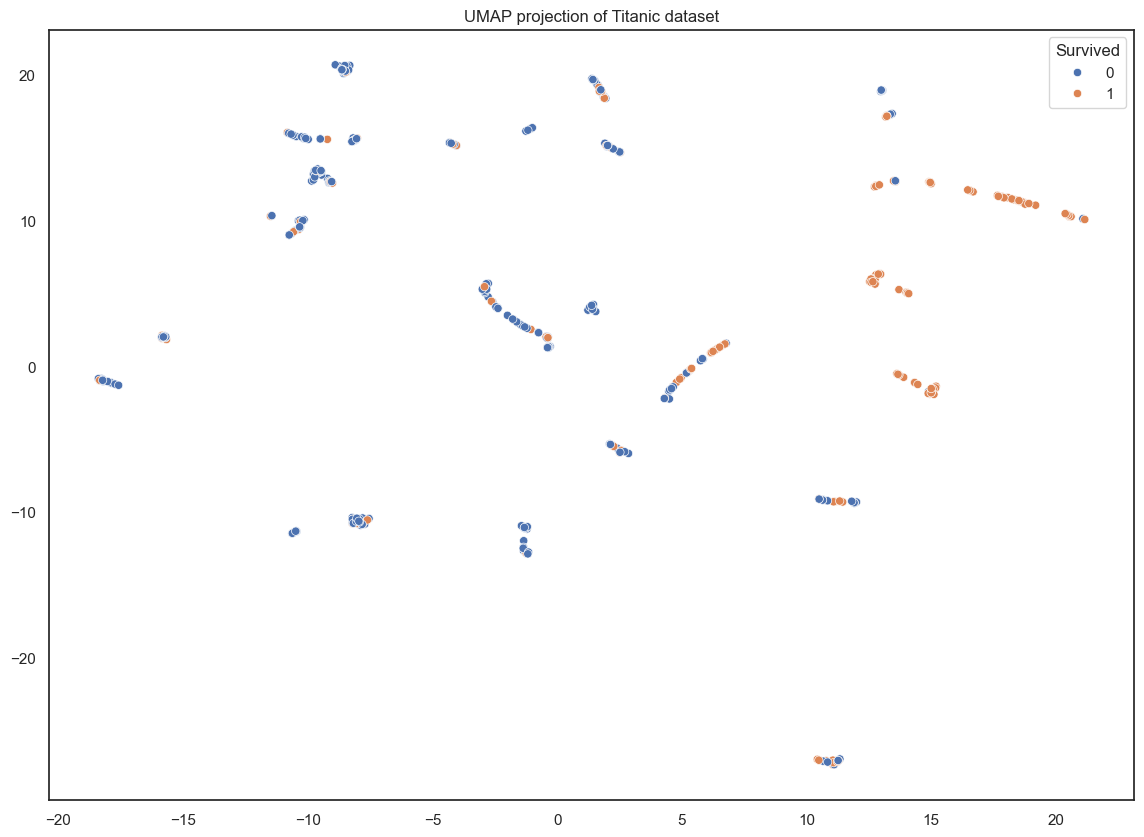

In [14]:
y = data_df['Survived']

umap_transformer = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.2
)

X_umap = umap_transformer.fit_transform(normalized_data)
X_umap_2 = umap_transformer.fit_transform(normalized_data_2)

sns.scatterplot(data=df, x=X_umap[:, 0], y=X_umap[:, 1], hue=y).set_title('UMAP projection of Titanic dataset')

Summary:
- from previous plot nothing special only combantion of 'Sex' and 'Cabin maybe
- we have to use UMAP, because other two functions need number of components and it is min from (number of features and unique class type-1). In our case it's 1 therefore we have only one axis and i dont know how to plot it then

In [15]:
#  checking the accuraccy after
#### AFTER  SELECTION ####################### CORRECT?

X = X_umap
y = data_df['Survived']
y = y.to_numpy()

X_test = X_umap_2
y_test = test_df['Survived']
y_test = y_test.to_numpy()

classifier.fit(X,y)
predicts = classifier.predict(X_test)
report = classification_report(y_test, predicts)
accuracy_after_3 = accuracy_score(y_test, predicts)

print("Accuracy after preprocessing: ", accuracy_after_3)

Accuracy after preprocessing:  0.7843137254901961


**4.Comparing results**

In [17]:
print("Accuracy before preprocessing: ", accuracy_before)
print("Accuracy after 1 preprocessing: ", accuracy_after_1)
print("Accuracy after 2 preprocessing: ", accuracy_after_2)
print("Accuracy after 3 preprocessing: ", accuracy_after_3)

Accuracy before preprocessing:  0.6974789915966386
Accuracy after 1 preprocessing:  0.7927170868347339
Accuracy after 2 preprocessing:  0.7675070028011205
Accuracy after 3 preprocessing:  0.7843137254901961
